In [472]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [473]:
df = pd.read_csv("data/Inventory_Waste_CompanyData.csv")
df.head()

,Job ID,Material Type,Area (sq/m),Thickness (mm),Material Cost (AED),Waste Percentage,Waste Cost (AED),Waste Class
0,JOB_1,PI,21.31,25.0,17048.49,0.0821,1400.50,Low
1,JOB_2,PI,20.70,25.0,16562.05,0.0907,1501.91,Low
2,JOB_3,PI,46.19,25.0,36955.73,0.0450,1663.69,Low
3,JOB_4,PI,16.42,25.0,13132.60,0.0759,996.62,Low
4,JOB_5,PI,38.02,30.0,36503.17,0.0530,1935.59,Low


In [474]:
df = df.dropna()
waste_threshold = 0.10
df['High_Waste'] = (df['Waste Percentage'] > waste_threshold).astype(int)

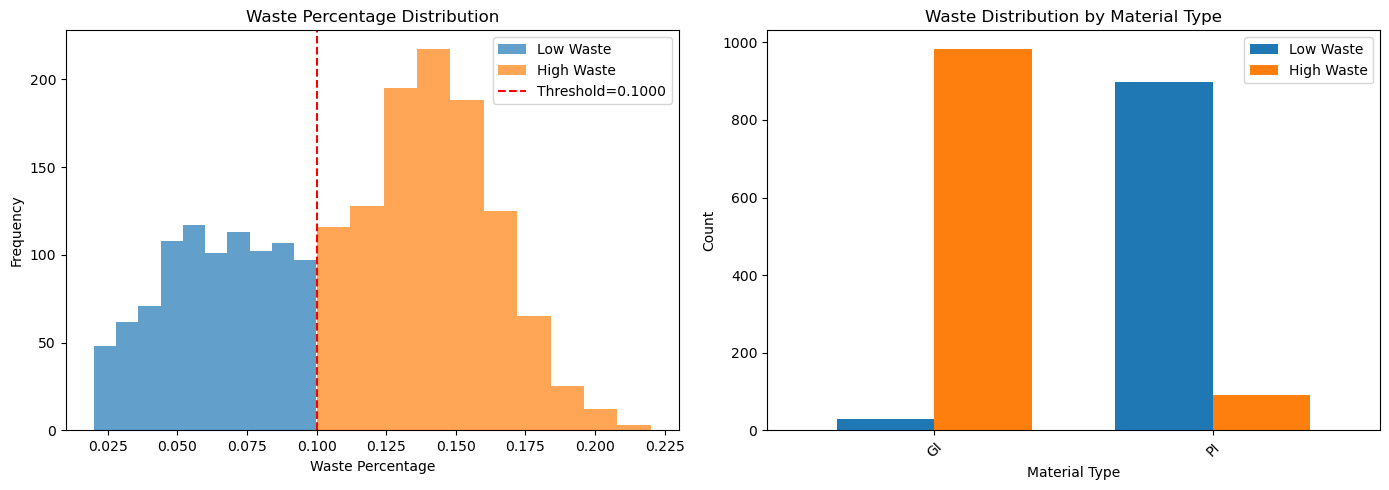

In [475]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df[df['High_Waste']==0]['Waste Percentage'], 
             alpha=0.7, label='Low Waste', bins=10)
axes[0].hist(df[df['High_Waste']==1]['Waste Percentage'], 
             alpha=0.7, label='High Waste', bins=10)
axes[0].axvline(x=waste_threshold, color='red', linestyle='--', 
                label=f'Threshold={waste_threshold:.4f}')
axes[0].set_xlabel('Waste Percentage')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Waste Percentage Distribution')
axes[0].legend()

waste_by_material = df.groupby(['Material Type', 'High_Waste']).size().unstack(fill_value=0)
waste_by_material.plot(kind='bar', ax=axes[1], width=0.7)
axes[1].set_xlabel('Material Type')
axes[1].set_ylabel('Count')
axes[1].set_title('Waste Distribution by Material Type')
axes[1].legend(['Low Waste', 'High Waste'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [476]:
features = ['Material Type', 'Area (sq/m)', 'Thickness (mm)', 'Material Cost (AED)']
target = 'High_Waste'

X = df[features].copy()
y = df[target]

label_encoder = LabelEncoder()
X['Material Type Encoded'] = label_encoder.fit_transform(X['Material Type'])

X = X.drop('Material Type', axis=1)

X.head()

,Area (sq/m),Thickness (mm),Material Cost (AED),Material Type Encoded
0,21.31,25.0,17048.49,1
1,20.70,25.0,16562.05,1
2,46.19,25.0,36955.73,1
3,16.42,25.0,13132.60,1
4,38.02,30.0,36503.17,1


In [477]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [478]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [479]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    knn, 
    param_grid, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

print()
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, we

In [480]:
knn = grid_search.best_estimator_

In [481]:
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)

print("CLASSIFICATION REPORT\n")

print(classification_report(y_test, y_test_pred, 
                          target_names=['Low Waste', 'High Waste']))

CLASSIFICATION REPORT

              precision    recall  f1-score   support

   Low Waste       0.91      0.97      0.94       185
  High Waste       0.98      0.92      0.94       215

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



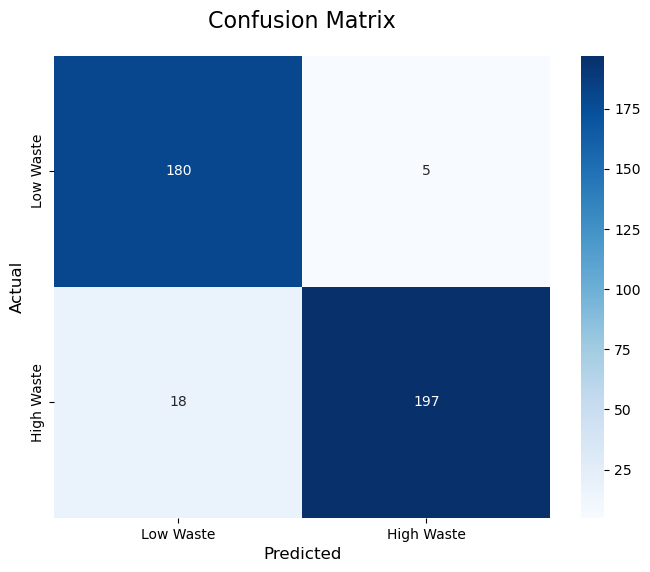

In [482]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Waste', 'High Waste'],
            yticklabels=['Low Waste', 'High Waste'])
plt.title('Confusion Matrix', fontsize=16, pad=20)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

In [483]:
def predict_waste(material_type, area, thickness, material_cost):
    try:
        material_encoded = label_encoder.transform([material_type])[0]
    except:
        print(f"Unknown material type: {material_type}")
        return None
    
    features = np.array([[area, thickness, material_cost, material_encoded]])
    
    features_scaled = scaler.transform(features)
    
    prediction = knn.predict(features_scaled)[0]
    probs = knn.predict_proba(features_scaled)[0]
    
    result = {
        'prediction': 'High Waste' if prediction == 1 else 'Low Waste',
        'prediction_code': int(prediction),
        'low_waste_prob': probs[0],
        'high_waste_prob': probs[1],
        'confidence': probs[prediction]
    }
    
    return result

In [484]:
test_cases = [
    {'material_type': 'PI', 'area': 35.0, 'thickness': 20, 'material_cost': 1100},
    {'material_type': 'GI', 'area': 10.0, 'thickness': 0.56, 'material_cost': 150}
]

for i, case in enumerate(test_cases, 1):
    print(f"Material: {case['material_type']}")
    print(f"Area: {case['area']} sq/m")
    print(f"Thickness: {case['thickness']} mm")
    print(f"Material Cost: {case['material_cost']} AED")
    
    result = predict_waste(
        case['material_type'], 
        case['area'], 
        case['thickness'], 
        case['material_cost']
    )
    
    if result:
        print(f"    Prediction: {result['prediction']}")
        print(f"    Probabilities: Low={result['low_waste_prob']:.2%}, "
              f"High={result['high_waste_prob']:.2%}")
    
    print()

Material: PI
Area: 35.0 sq/m
Thickness: 20 mm
Material Cost: 1100 AED
    Prediction: Low Waste
    Probabilities: Low=100.00%, High=0.00%

Material: GI
Area: 10.0 sq/m
Thickness: 0.56 mm
Material Cost: 150 AED
    Prediction: High Waste
    Probabilities: Low=0.00%, High=100.00%



/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
